In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seastar
# from cycler import cycler


In [2]:
def reduce_0_360_to_0_180(input_degree):
    """
    Convert the direction range 0-360 to 0-180 assuming a symetry around zero. Useful for GMFs in Sigma0 or WASV.

    Parameters
    ----------
    input_degree : ``numpy``, ``xarray``

    Returns
    -------
    output in the same format as the input
    """
    return( np.abs(((input_degree + 180) % 360) - 180) )

In [3]:
Kp_sqt = 0.03
Kp_broad = 0.04

In [4]:
wspd_target = [5, 9, 15]
pol_target = [1]
inci_broad_target = [20, 28.4, 33.4]
inci_sqt_target = [31.5, 36.5, 40.0]
# sqt_ground = [52.2, 45.0, 37.8] # Fix squint of 45°
across_distance = [0, 90, 150]

In [5]:
# azi_lw = [2, .5]
# azi_ls = ['-', '--']
# azi_str = ['upwind', 'crosswind']
# pol_ls = ['-', '--']
# pol_lw = [2, .5]
# pol_str = ['VV', 'HH']
# wspd_lw = [.5, 1, 2]

In [6]:
# sigma0_lim = [10**-3.2, 10**0.5]
# inci_lim = [15, 45] # available data [16,65]
wspd_lim = [1, 20]

# Sensitivity to Wind Direction

In [7]:
azi_step =  5

pol   =  np.array([1])
wspd  =  np.array( wspd_target )
theta_broad =  np.array( inci_broad_target )
theta_sqt =  np.array( inci_sqt_target )
azi   =  np.arange(0, 360, azi_step)

[wspd_mat, theta_broad_mat, azi_mat, pol_mat] =  np.meshgrid(wspd, theta_broad, azi, pol, indexing='ij')
[wspd_mat, theta_sqt_mat, azi_mat, pol_mat] =  np.meshgrid(wspd, theta_sqt, azi, pol, indexing='ij')

s0_lin_broad = seastar.gmfs.nrcs.nscat4ds(
    wspd_mat,
    reduce_0_360_to_0_180(azi_mat),
    theta_broad_mat,
    pol_mat,
)

s0_lin_sqt = seastar.gmfs.nrcs.nscat4ds(
    wspd_mat,
    reduce_0_360_to_0_180(azi_mat),
    theta_sqt_mat,
    pol_mat,
)

In [9]:
ds = xr.Dataset(
    data_vars=dict(
        sigma0_lin=(['wspd','cell','azi','pol','antenna'], np.stack([s0_lin_broad, s0_lin_sqt], axis=-1))
    ),
    coords=dict(
        cell = ['near', 'mid', 'far'],
        inci_broad = (('cell'), inci_broad_target),
        inci_sqt = (('cell'), inci_sqt_target),
        antenna = ['broad', 'sqt'],
        wspd=wspd,
        azi=azi,
        pol=pol,
#         sqt_ground = (('cell'), sqt_ground),
        across_distance =  (('cell'), across_distance),
    )
)
ds.sigma0_lin.attrs['units'] = 'lin'
ds.sigma0_lin.attrs['long_name'] = 'sigma0'
ds.wspd.attrs['long_name'] = 'Wind Speed'
ds.wspd.attrs['units'] = 'm/s'
ds.inci_broad.attrs['long_name'] = 'Incidence Angle'
ds.inci_broad.attrs['units'] = '°'
ds.inci_sqt.attrs['long_name'] = 'Incidence Angle'
ds.inci_sqt.attrs['units'] = '°'
ds.azi.attrs['long_name'] = 'Relative Azimuth Angle'
ds.azi.attrs['units'] = '°'

ds = ds.squeeze()

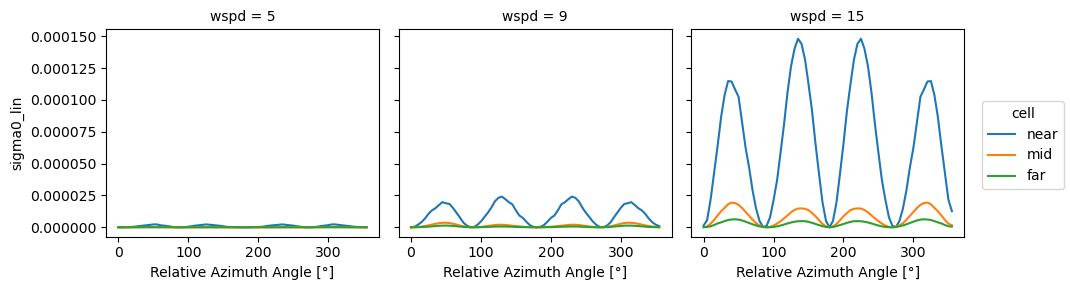

In [10]:
(ds.sigma0_lin.differentiate('azi')**2).sel(antenna='broad').plot(x='azi',col='wspd',hue='cell')

In [11]:
ds['ds0lin_dazi_2'] = ds.sigma0_lin.differentiate('azi')**2
ds['mean_s0lin'] = ds.sigma0_lin.mean(dim='azi')

In [12]:
# ds['shift_fore'] = np.round((90-ds.sqt_ground)/azi_step)
# ds['shift_aft'] = np.round((90+ds.sqt_ground)/azi_step)
# ds['shift_fore'] = np.round(45/azi_step)
# ds['shift_broad'] = np.round(90/azi_step)
# ds['shift_aft'] = np.round(135/azi_step)
shift_fore  = int(np.round(45/azi_step))
shift_broad = int(np.round(90/azi_step))
shift_aft   = int(np.round(135/azi_step))

ds['norm_ds0lindazi_2_fore'] = ds.ds0lin_dazi_2.roll(azi=shift_fore).sel(antenna='sqt') / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
ds['norm_ds0lindazi_2_broad'] = ds.ds0lin_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / (Kp_broad * ds.mean_s0lin.sel(antenna='broad') )**2
ds['norm_ds0lindazi_2_aft'] = ds.ds0lin_dazi_2.roll(azi=shift_aft).sel(antenna='sqt')  / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
ds['norm_ds0lindazi_2_tot_sqt'] = ds['norm_ds0lindazi_2_fore'] + ds['norm_ds0lindazi_2_aft']
ds['norm_ds0lindazi_2_tot'] = ds['norm_ds0lindazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_broad']

In [13]:
# Test for the normalisation with Sigma0 at the given azimuth instead of the mean sigma0 over all azimuth 
# => Does not affect dramaticaly the results, same behaviour even if changes at the peak of sensitivity (not strong at Near + low WSpd)
ds['norm_ds0lindazi_2b_broad'] = ds.ds0lin_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / (Kp_broad * ds.sigma0_lin.sel(antenna='broad') )**2
# ds['norm_ds0lindazi_2_fore'] = ds.ds0lin_dazi_2.roll(azi=shift_fore).sel(antenna='sqt') / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
# ds['norm_ds0lindazi_2_aft'] = ds.ds0lin_dazi_2.roll(azi=shift_aft).sel(antenna='sqt')  / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
# ds['norm_ds0lindazi_2_tot_sqt'] = ds['norm_ds0lindazi_2_fore'] + ds['norm_ds0lindazi_2_aft']
# ds['norm_ds0lindazi_2_tot'] = ds['norm_ds0lindazi_2_tot_sqt'] + ds['norm_ds0lindazi_2_broad']

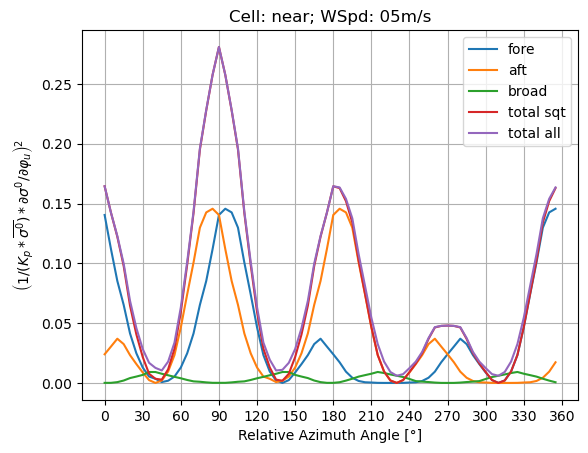

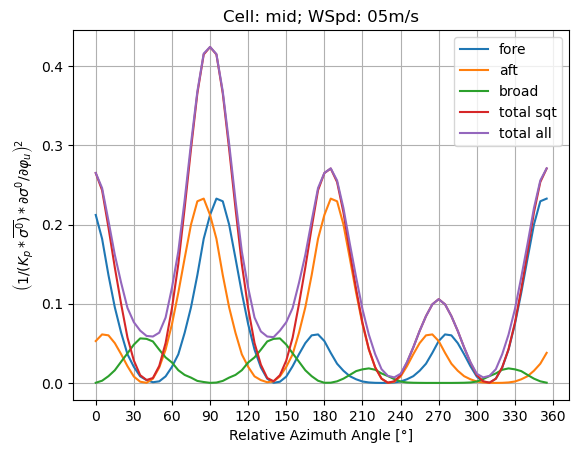

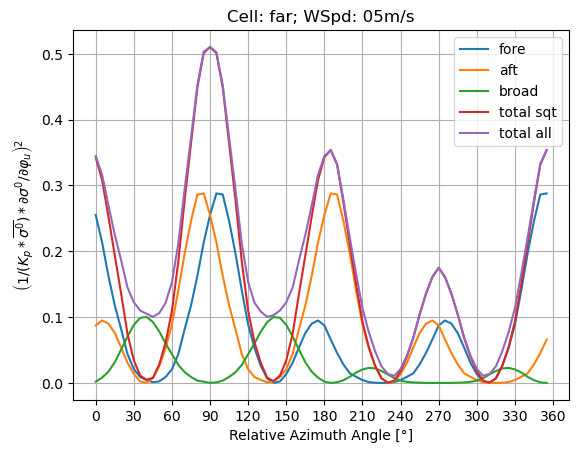

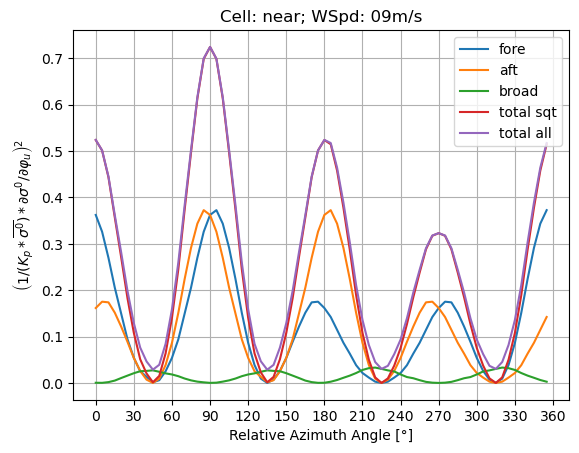

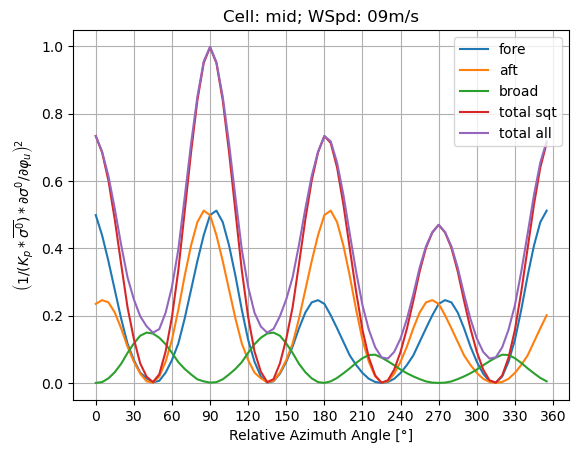

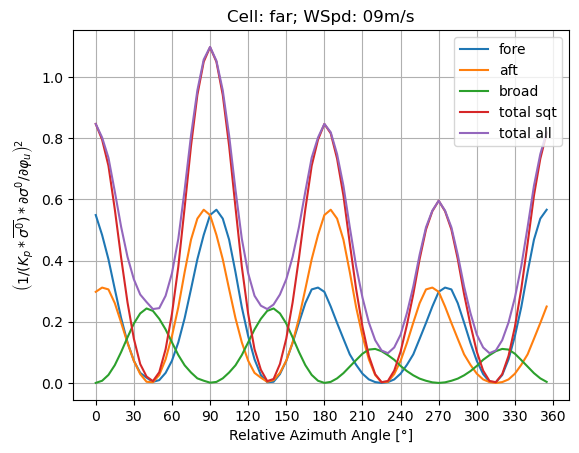

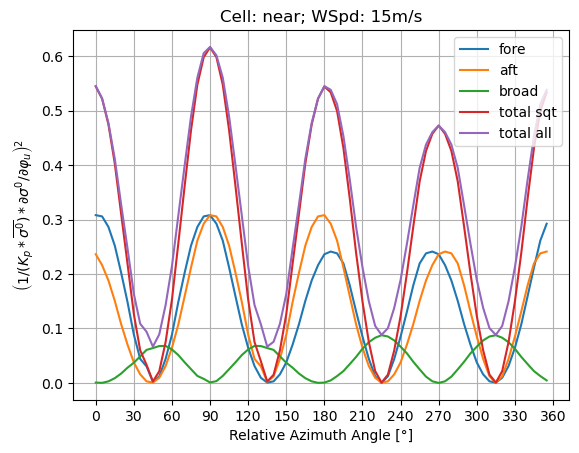

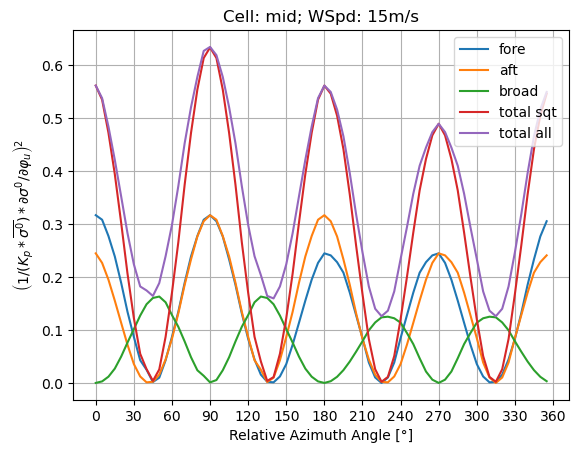

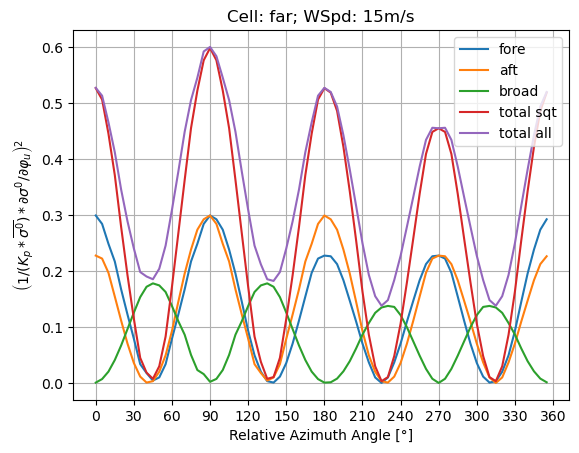

In [14]:
for wspd in wspd_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_ds0lindazi_2_fore\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_ds0lindazi_2_aft\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_ds0lindazi_2_broad\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='broad',
                )
#         ds.norm_ds0lindazi_2b_broad\
#             .sel(cell=cell)\
#             .sel(wspd=wspd)\
#             .plot(
#                 ax=ax,
#                 label='b_broad',
#                 )
        ds.norm_ds0lindazi_2_tot_sqt\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_ds0lindazi_2_tot\
            .sel(cell=cell)\
            .sel(wspd=wspd)\
            .plot(
                ax=ax,
                label='total all',
                )
        plt.xticks(np.arange(0,361,30))
        plt.grid()
        plt.title(f'Cell: {cell}; WSpd: {wspd:02.0f}m/s')
        plt.legend()
        plt.ylabel(r'$\left(1/(K_p * \overline{\sigma^0}) * \partial{\sigma^0}/\partial{\varphi_u}\right)^2$')

# Sensitivity to Wind Speed

In [15]:
azi_step =  45
wspd_step = 1

pol   =  np.array([1])
wspd  =  np.arange(wspd_lim[0], wspd_lim[-1], wspd_step)
theta_broad =  np.array( inci_broad_target )
theta_sqt =  np.array( inci_sqt_target )
azi   =  np.arange(0, 360, azi_step)

[wspd_mat, theta_broad_mat, azi_mat, pol_mat] =  np.meshgrid(wspd, theta_broad, azi, pol, indexing='ij')
[wspd_mat, theta_sqt_mat, azi_mat, pol_mat] =  np.meshgrid(wspd, theta_sqt, azi, pol, indexing='ij')

s0_lin_broad = seastar.gmfs.nrcs.nscat4ds(
    wspd_mat,
    reduce_0_360_to_0_180(azi_mat),
    theta_broad_mat,
    pol_mat,
)

s0_lin_sqt = seastar.gmfs.nrcs.nscat4ds(
    wspd_mat,
    reduce_0_360_to_0_180(azi_mat),
    theta_sqt_mat,
    pol_mat,
)

In [16]:
ds = xr.Dataset(
    data_vars=dict(
        sigma0_lin=(['wspd','cell','azi','pol','antenna'], np.stack([s0_lin_broad, s0_lin_sqt], axis=-1))
    ),
    coords=dict(
        cell = ['near', 'mid', 'far'],
        inci_broad = (('cell'), inci_broad_target),
        inci_sqt = (('cell'), inci_sqt_target),
        antenna = ['broad', 'sqt'],
        wspd=wspd,
        azi=azi,
        pol=pol,
#         sqt_ground = (('cell'), sqt_ground),
        across_distance =  (('cell'), across_distance),
    )
)
ds.sigma0_lin.attrs['units'] = 'lin'
ds.sigma0_lin.attrs['long_name'] = 'sigma0'
ds.wspd.attrs['long_name'] = 'Wind Speed'
ds.wspd.attrs['units'] = 'm/s'
ds.inci_broad.attrs['long_name'] = 'Incidence Angle'
ds.inci_broad.attrs['units'] = '°'
ds.inci_sqt.attrs['long_name'] = 'Incidence Angle'
ds.inci_sqt.attrs['units'] = '°'
ds.azi.attrs['long_name'] = 'Relative Azimuth Angle'
ds.azi.attrs['units'] = '°'

ds = ds.squeeze()

In [17]:
ds

<xarray.Dataset>
Dimensions:          (wspd: 19, cell: 3, azi: 8, antenna: 2)
Coordinates:
  * cell             (cell) <U4 'near' 'mid' 'far'
    inci_broad       (cell) float64 20.0 28.4 33.4
    inci_sqt         (cell) float64 31.5 36.5 40.0
  * antenna          (antenna) <U5 'broad' 'sqt'
  * wspd             (wspd) int32 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19
  * azi              (azi) int32 0 45 90 135 180 225 270 315
    pol              int32 1
    across_distance  (cell) int32 0 90 150
Data variables:
    sigma0_lin       (wspd, cell, azi, antenna) float64 0.02887 ... 0.1226

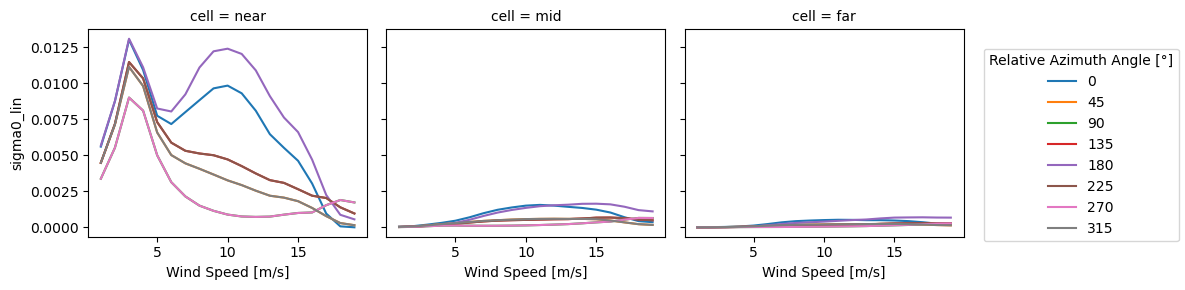

In [18]:
(ds.sigma0_lin.differentiate('wspd')**2).sel(antenna='broad').plot(x='wspd',col='cell',hue='azi')

In [19]:
ds['ds0lin_dwspd_2'] = ds.sigma0_lin.differentiate('wspd')**2
ds['mean_s0lin'] = ds.sigma0_lin.mean(dim='azi')

In [20]:
# ds['shift_fore'] = np.round((90-ds.sqt_ground)/azi_step)
# ds['shift_aft'] = np.round((90+ds.sqt_ground)/azi_step)
# ds['shift_fore'] = np.round(45/azi_step)
# ds['shift_broad'] = np.round(90/azi_step)
# ds['shift_aft'] = np.round(135/azi_step)
shift_fore  = int(np.round(45/azi_step))
shift_broad = int(np.round(90/azi_step))
shift_aft   = int(np.round(135/azi_step))

ds['norm_ds0lindwspd_2_fore'] = ds.ds0lin_dwspd_2.roll(azi=shift_fore).sel(antenna='sqt') / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
ds['norm_ds0lindwspd_2_broad'] = ds.ds0lin_dwspd_2.roll(azi=shift_broad).sel(antenna='broad')  / (Kp_broad * ds.mean_s0lin.sel(antenna='broad') )**2
ds['norm_ds0lindwspd_2_aft'] = ds.ds0lin_dwspd_2.roll(azi=shift_aft).sel(antenna='sqt')  / (Kp_sqt * ds.mean_s0lin.sel(antenna='sqt') )**2
ds['norm_ds0lindwspd_2_tot_sqt'] = ds['norm_ds0lindwspd_2_fore'] + ds['norm_ds0lindwspd_2_aft']
ds['norm_ds0lindwspd_2_tot'] = ds['norm_ds0lindwspd_2_tot_sqt'] + ds['norm_ds0lindwspd_2_broad']

C:\Users\adrien-NOV\AppData\Local\Temp\ipykernel_19764\3553936825.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


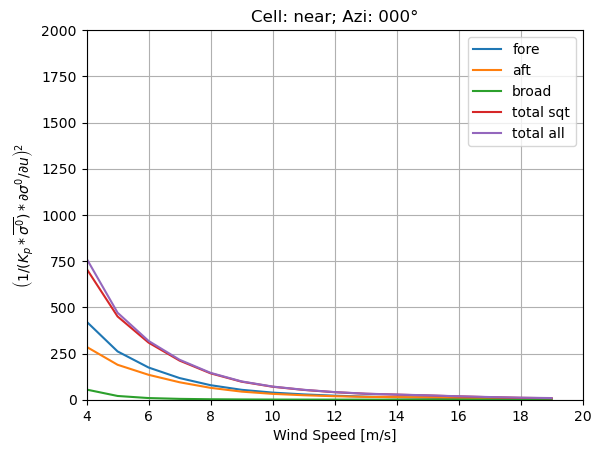

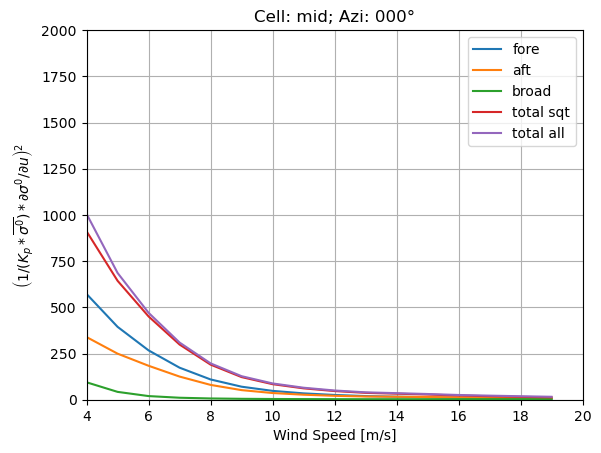

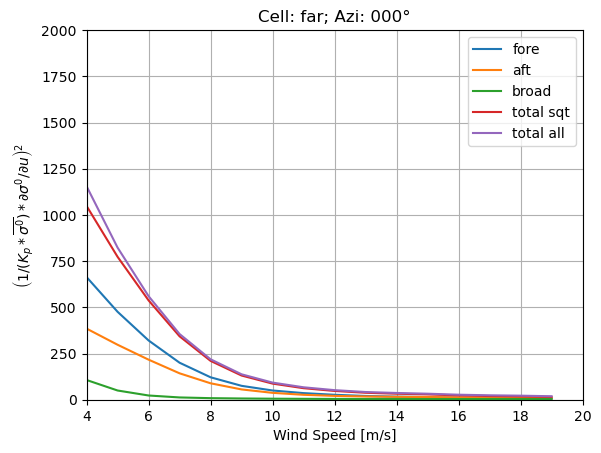

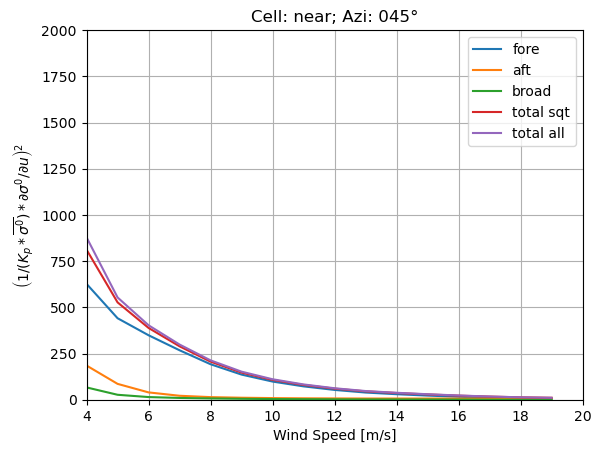

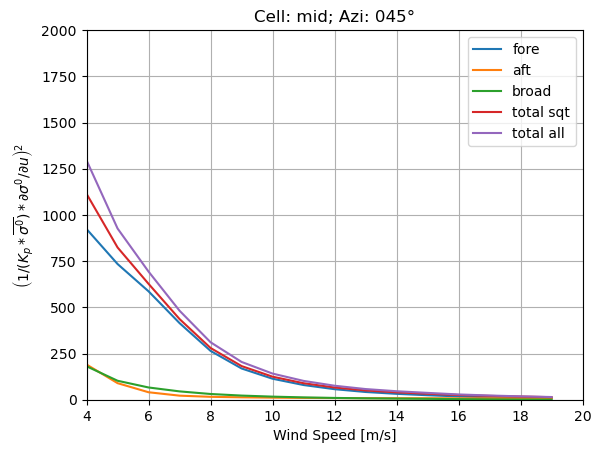

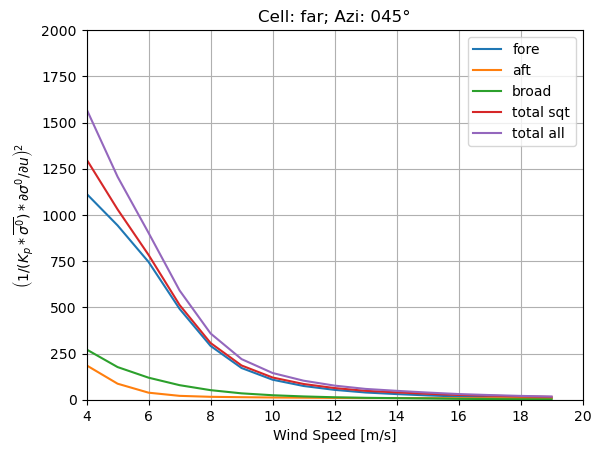

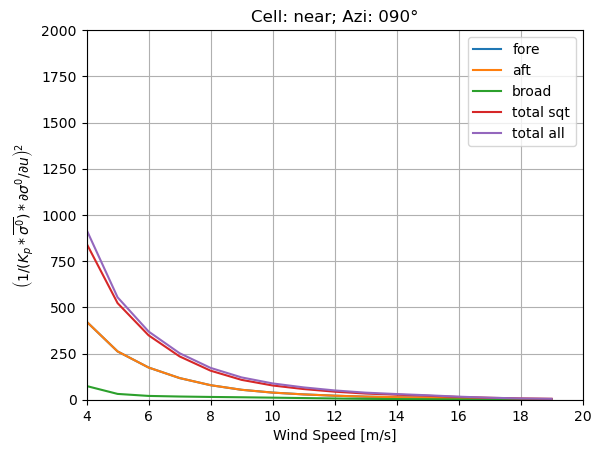

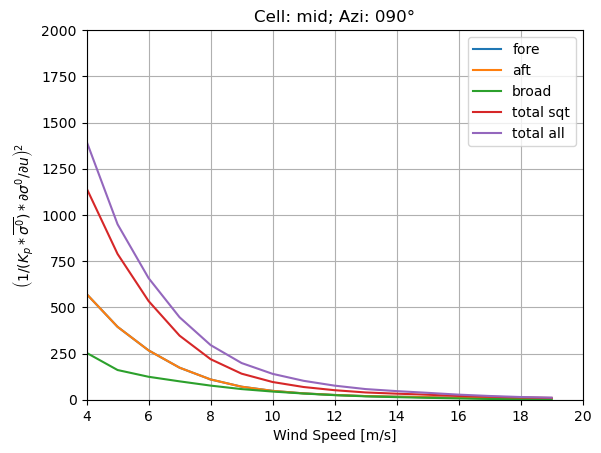

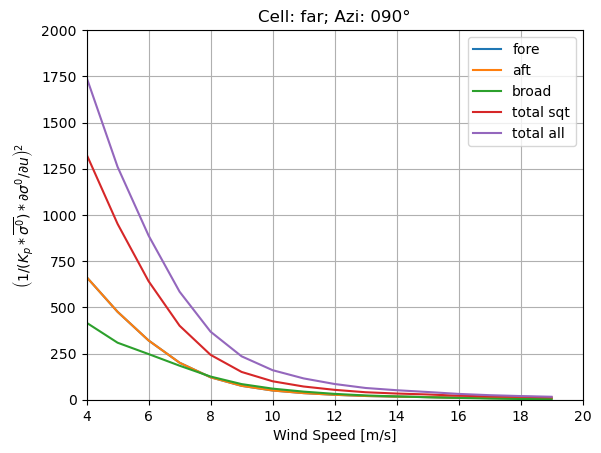

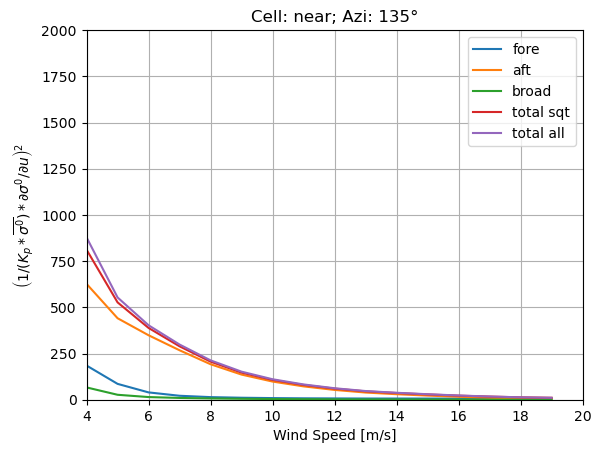

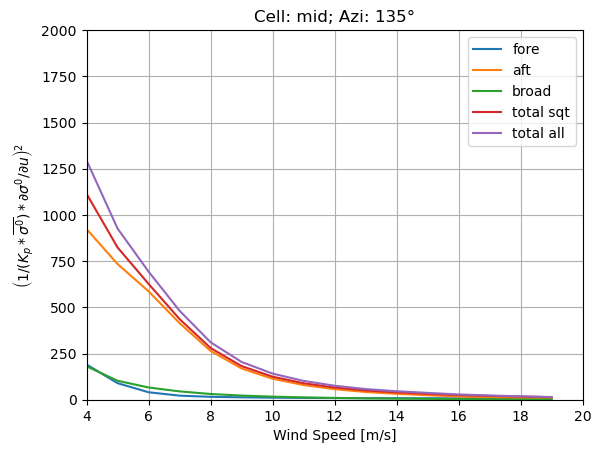

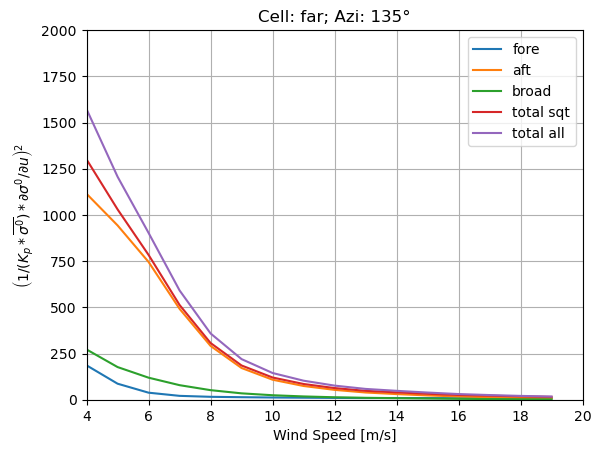

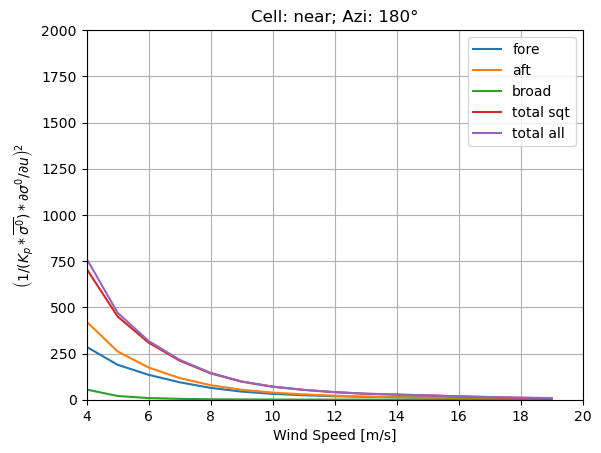

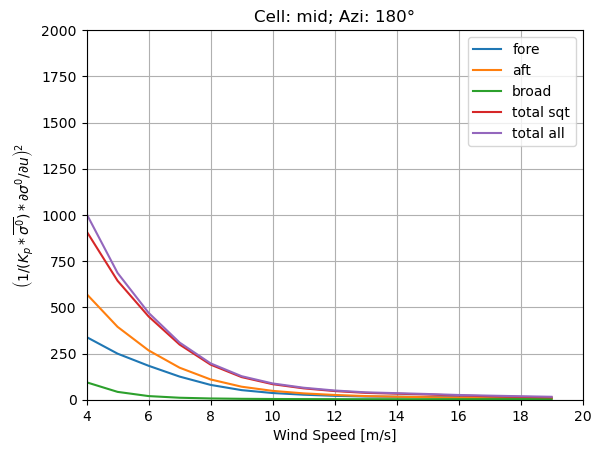

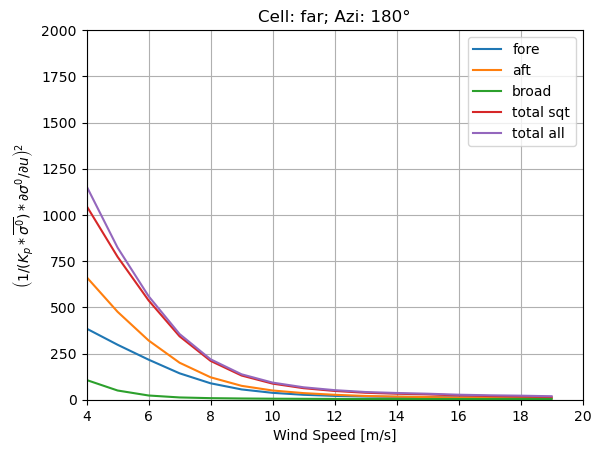

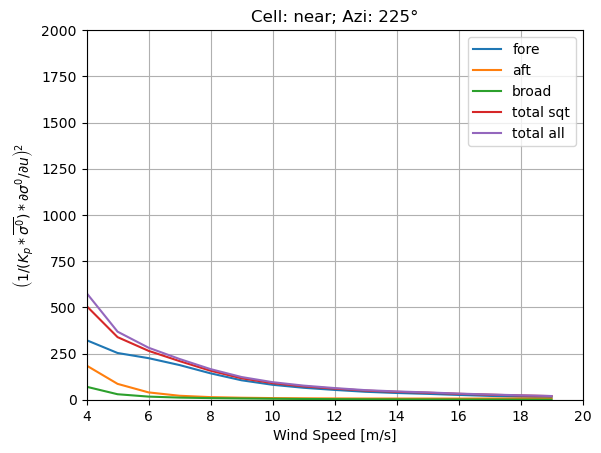

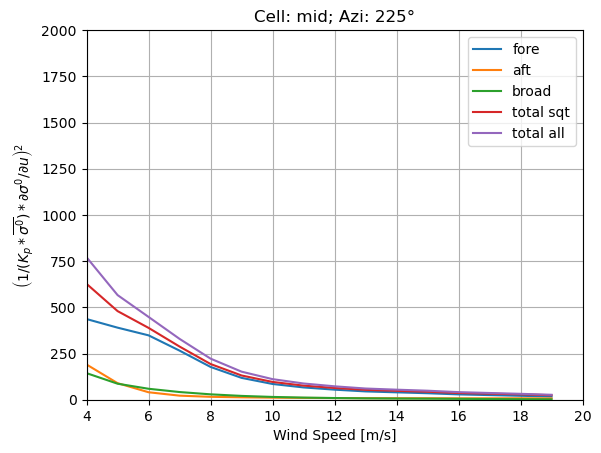

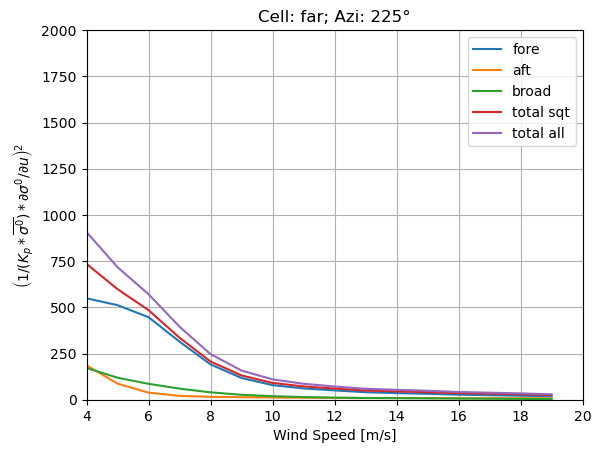

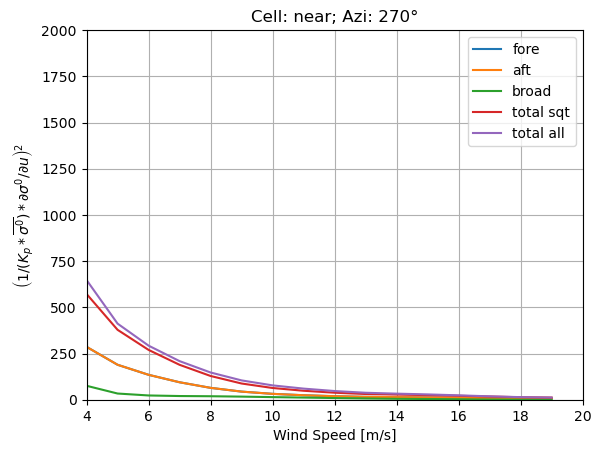

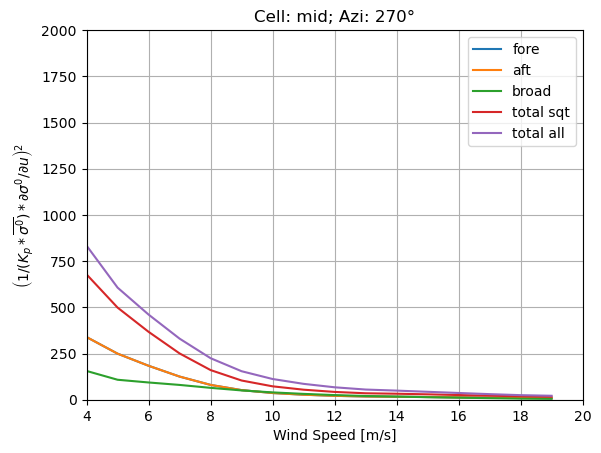

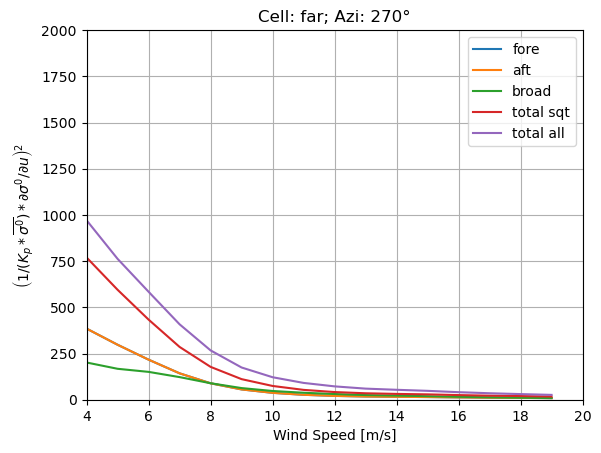

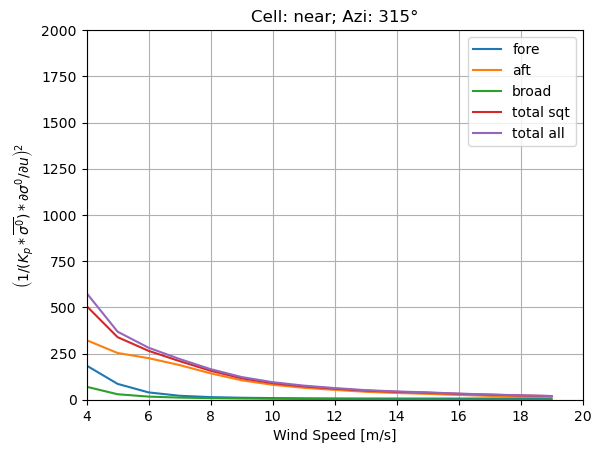

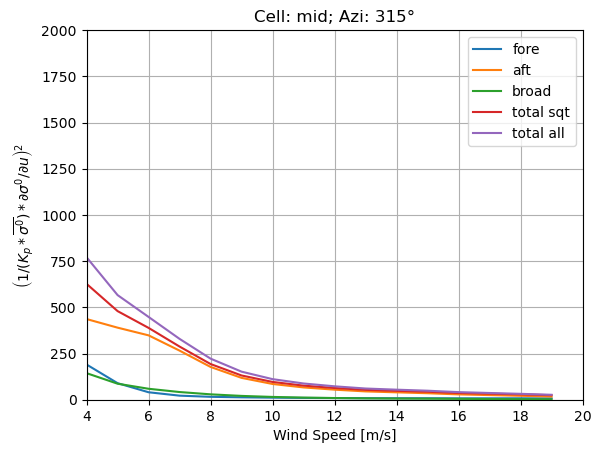

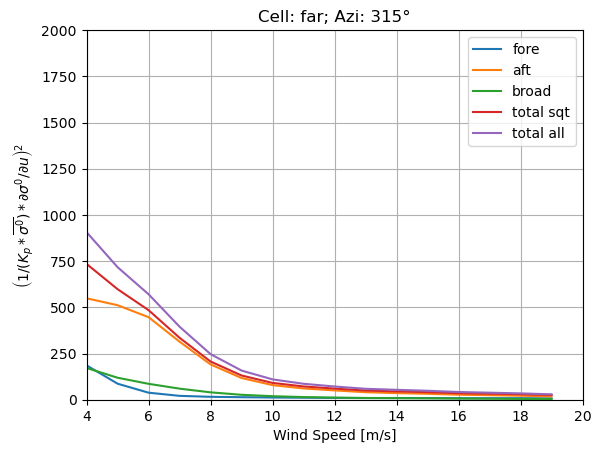

In [21]:
for azi in ds.azi.values:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_ds0lindwspd_2_fore\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_ds0lindwspd_2_aft\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_ds0lindwspd_2_broad\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='broad',
                )
#         ds.norm_ds0lindwspd_2b_broad\
#             .sel(cell=cell)\
#             .sel(azi=azi)\
#             .plot(
#                 ax=ax,
#                 label='b_broad',
#                 )
        ds.norm_ds0lindwspd_2_tot_sqt\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_ds0lindwspd_2_tot\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='total all',
                )
        plt.xlim([4, 20])
        plt.ylim([0,2000])
#         plt.xticks(np.arange(4,361,30))
        plt.grid()
        plt.title(f'Cell: {cell}; Azi: {azi:03.0f}°')
        plt.legend()
        plt.ylabel(r'$\left(1/(K_p * \overline{\sigma^0}) * \partial{\sigma^0}/\partial{u}\right)^2$')